In [21]:
# ============================================================
# Cell 1. 导入依赖
# ============================================================
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx  # 加底图 (Web Mercator)
import seaborn as sns

# 设置 matplotlib 样式
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 120

# 输出目录
OUT_MAP = "_gis_maps"
OUT_TAB = "_gis_tables"
os.makedirs(OUT_MAP, exist_ok=True)
os.makedirs(OUT_TAB, exist_ok=True)

In [22]:
# ============================================================
# Cell 2. 读入数据 (NDVI CSV + 边界)
# ============================================================
NDVI_CSV = "ETH_AwashKesem_NDVImean_byKebele_2018_2024_v01.csv"
ADM_GEOJSON = "Ethiopia_AdminBoundaries.geojson"   # 建议用 geojson, 不用 shp

# 读 NDVI
ndvi = pd.read_csv(NDVI_CSV)
print("NDVI CSV 列：", ndvi.columns.tolist())
print(ndvi.head())

# 读边界
adm = gpd.read_file(ADM_GEOJSON)
print("边界文件列：", adm.columns.tolist())

# 确认 join key
if "Kebele_ID" in adm.columns:
    adm["unit_id"] = adm["Kebele_ID"].astype(str)
elif "GlobalID" in adm.columns:
    adm["unit_id"] = adm["GlobalID"].astype(str)
else:
    raise ValueError("边界文件缺少 kebele 唯一 ID，请确认")

ndvi["unit_id"] = ndvi["Kebele_ID"].astype(str)

# 合并属性
g = adm.merge(ndvi, on="unit_id", how="inner")
g = g.set_crs(epsg=4326).to_crs(epsg=3857)  # 转 Web Mercator 方便画底图

print("合并后行数：", len(g))

NDVI CSV 列： ['Kebele_ID', 'Kebele_Name', 'W_NAME', 'Z_NAME', 'T_NAME', 'treated', 'treat_share', 'area_km2', 'Year', 'NDVI']
                              Kebele_ID Kebele_Name   W_NAME    Z_NAME  \
0  ecba1d05-116b-4e2d-ba3f-5d4c516ba924     Amibara  Amibara  Zone  03   
1  d37ccaf0-a552-4cfd-a6b8-6f993befac3c     Amibara  Amibara  Zone  03   
2  1021bd68-97ce-47dd-9b32-98ab9a912b06     Amibara  Amibara  Zone  03   
3  e408d40e-19e4-4887-81ef-56403947d7f5     Amibara  Amibara  Zone  03   
4  2a879845-b5d4-47d5-8d00-e193da0011f8     Amibara  Amibara  Zone  03   

   T_NAME  treated  treat_share   area_km2    Year  NDVI  
0     NaN        1     1.000000  15.006547  2018.0   NaN  
1     NaN        1     0.832011  80.132813  2018.0   NaN  
2     NaN        1     1.000000   1.056063  2018.0   NaN  
3     NaN        1     1.000000   1.439481  2018.0   NaN  
4     NaN        1     1.000000   2.168503  2018.0   NaN  
边界文件列： ['OBJECTID', 'R_NAME', 'R_CODE', 'Z_NAME', 'Z_CODE', 'W_NAME', 'W_COD

treated 分布：
 treated
0    5817
1     273
Name: count, dtype: int64
年份范围： 2018.0 - 2024.0


ValueError: List of boxplot statistics and `positions` values must have same the length

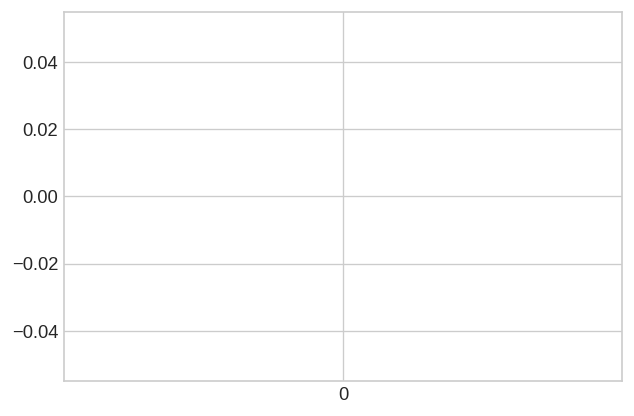

In [23]:
# ============================================================
# Cell 3. 描述性统计
# ============================================================
print("treated 分布：\n", g["treated"].value_counts(dropna=False))
print("年份范围：", g["Year"].min(), "-", g["Year"].max())

plt.figure(figsize=(6,4))
sns.boxplot(data=g, x="treated", y="NDVI")
plt.title("NDVI 分布 (Treated vs Control)")
plt.xlabel("Treatment group (0=Control, 1=Treated)")
plt.ylabel("NDVI")
plt.show()


In [25]:
# ============================================================
# Cell 4. 地图可视化函数
# ============================================================
def choropleth(gdf, col, title, cmap="YlGn", fname=None, with_basemap=True, vmin=None, vmax=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))
    gdf.plot(column=col, ax=ax, cmap=cmap, linewidth=0.2, edgecolor="gray",
             legend=True, vmin=vmin, vmax=vmax)

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()

    if with_basemap:
        try:
            ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
        except:
            print("⚠️ Basemap 加载失败（可能无网），地图仍然会画")

    if fname:
        outpath = os.path.join(OUT_MAP, fname)
        plt.savefig(outpath, dpi=200, bbox_inches="tight")
        print("✅ saved:", outpath)
    plt.show()

⚠️ Basemap 加载失败（可能无网），地图仍然会画
✅ saved: _gis_maps/NDVI_2019.png


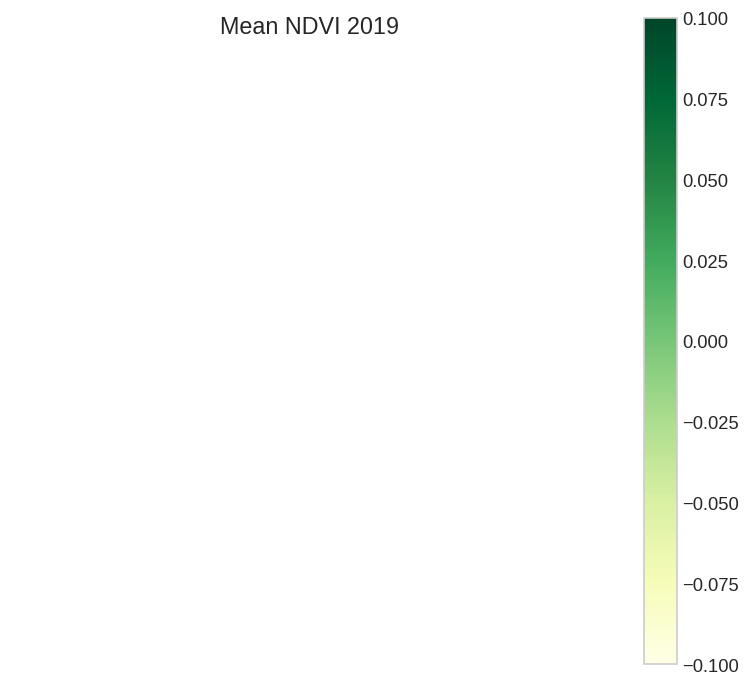

⚠️ Basemap 加载失败（可能无网），地图仍然会画
✅ saved: _gis_maps/NDVI_2024.png


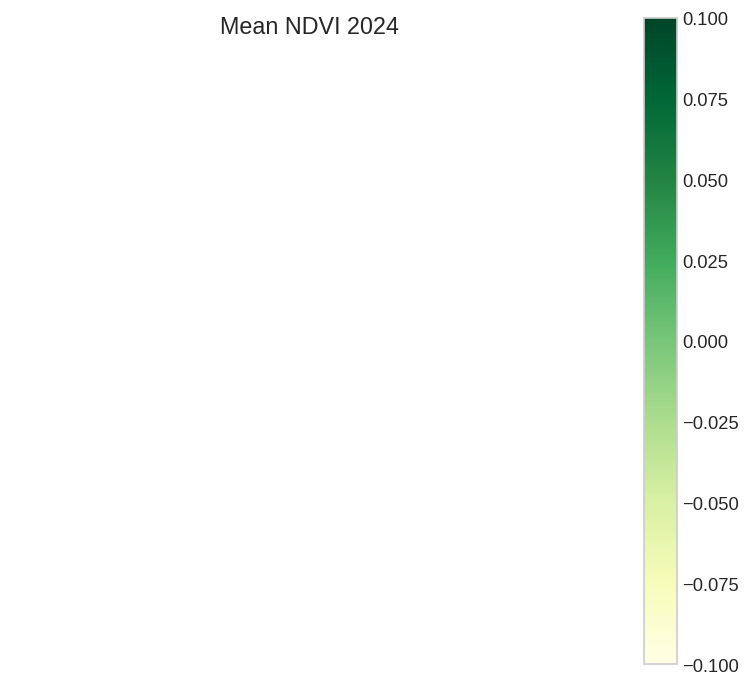

⚠️ Basemap 加载失败（可能无网），地图仍然会画
✅ saved: _gis_maps/NDVI_change_2019_2024.png


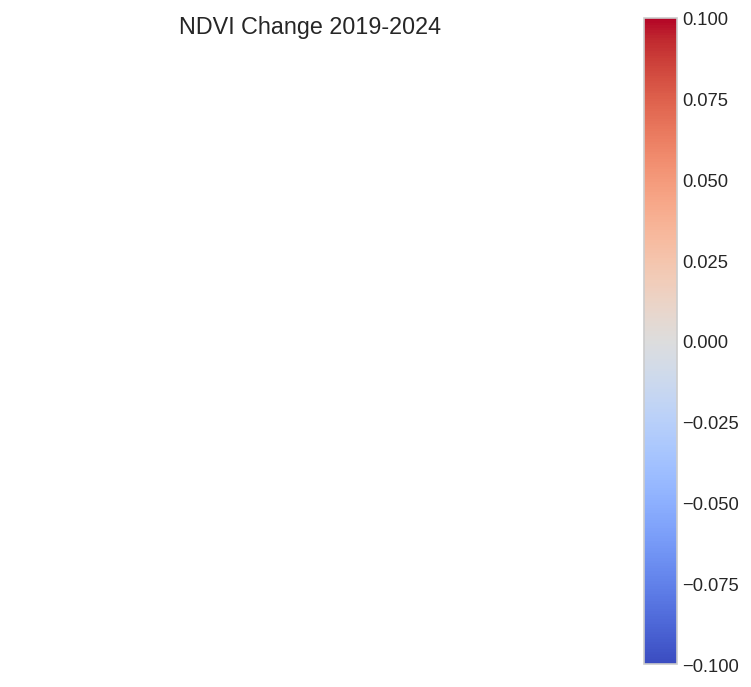

In [26]:

# ============================================================
# Cell 5. 年度 NDVI 地图 (2019 vs 2024)
# ============================================================
year0, year1 = 2019, 2024

g0 = g[g["Year"] == year0]
g1 = g[g["Year"] == year1]

# 同一色阶
vmin, vmax = g["NDVI"].min(), g["NDVI"].max()

choropleth(g0, "NDVI", f"Mean NDVI {year0}", cmap="YlGn",
           fname=f"NDVI_{year0}.png", vmin=vmin, vmax=vmax)

choropleth(g1, "NDVI", f"Mean NDVI {year1}", cmap="YlGn",
           fname=f"NDVI_{year1}.png", vmin=vmin, vmax=vmax)

# NDVI 变化
gdelta = g1[["unit_id","NDVI","geometry"]].merge(
    g0[["unit_id","NDVI"]], on="unit_id", suffixes=("_y1","_y0"))
gdelta["NDVI_change"] = gdelta["NDVI_y1"] - gdelta["NDVI_y0"]

choropleth(gdelta, "NDVI_change", f"NDVI Change {year0}-{year1}",
           cmap="coolwarm", fname=f"NDVI_change_{year0}_{year1}.png")

In [27]:
# ============================================================
# Cell 6. 按行政区聚合统计 (Zone)
# ============================================================
zone_stats = g.groupby(["Z_NAME","Year"])["NDVI"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=zone_stats, x="Year", y="NDVI", hue="Z_NAME", marker="o")
plt.title("NDVI 时间趋势 (Zone)")
plt.ylabel("Mean NDVI")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(OUT_MAP,"NDVI_trend_by_zone.png"), dpi=200)
plt.show()

KeyError: 'Z_NAME'